# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

C:\Users\login\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv('data/data.csv', encoding='latin')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#  Exploratory data analysis

##  statistical overview

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Dealing with types

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

## Dealing with null values


* delete rows with null values
* delete the feature with null values
* impute data with mean or median values or use another imputing strategy (method *.fillna()*)

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerID has too much null values and this feature cannot predict a lot so we can just drop it. Also it could be reasonable to create another feature "Amount of orders per customer", but.... next time ;)

In [8]:
df = df.drop(columns=['CustomerID'])

Let's check out what kind of nulls we have in Description

In [9]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales. I think, we can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [10]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

##  Checking out columns separately

In [11]:
df['Description'].value_counts().head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64

Here we can see our best selling products, items that appear in orders the most often. Also to make it visually more appealing let's create a bar chart for 15 top items.

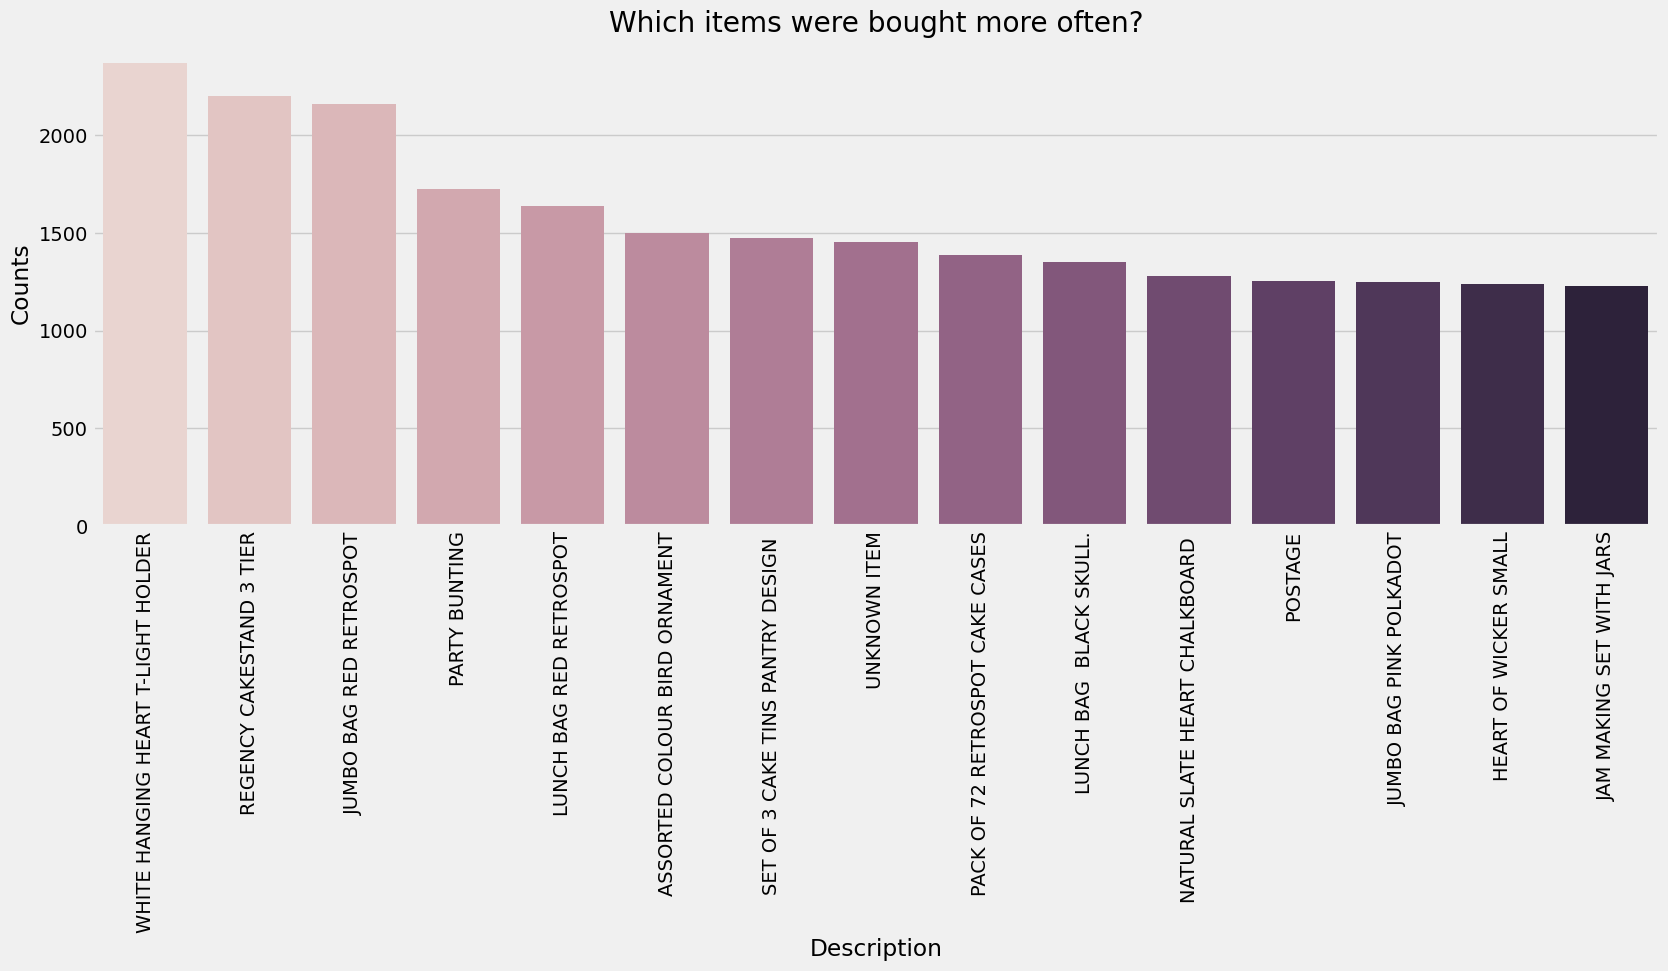

In [14]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=item_counts.index, y=item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [15]:
df['Description'].value_counts().tail()

Description
Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: count, dtype: int64

We also notice from above code that valid items are normally uppercased and non-valid or cancelations are in lower case

In [16]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Description
Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: count, dtype: int64

Quick check of the case of letters in Description says that there are some units with lower case letters in their name and also that lower case records are for canceled items. Here we can understand that data management in the store can be improved.

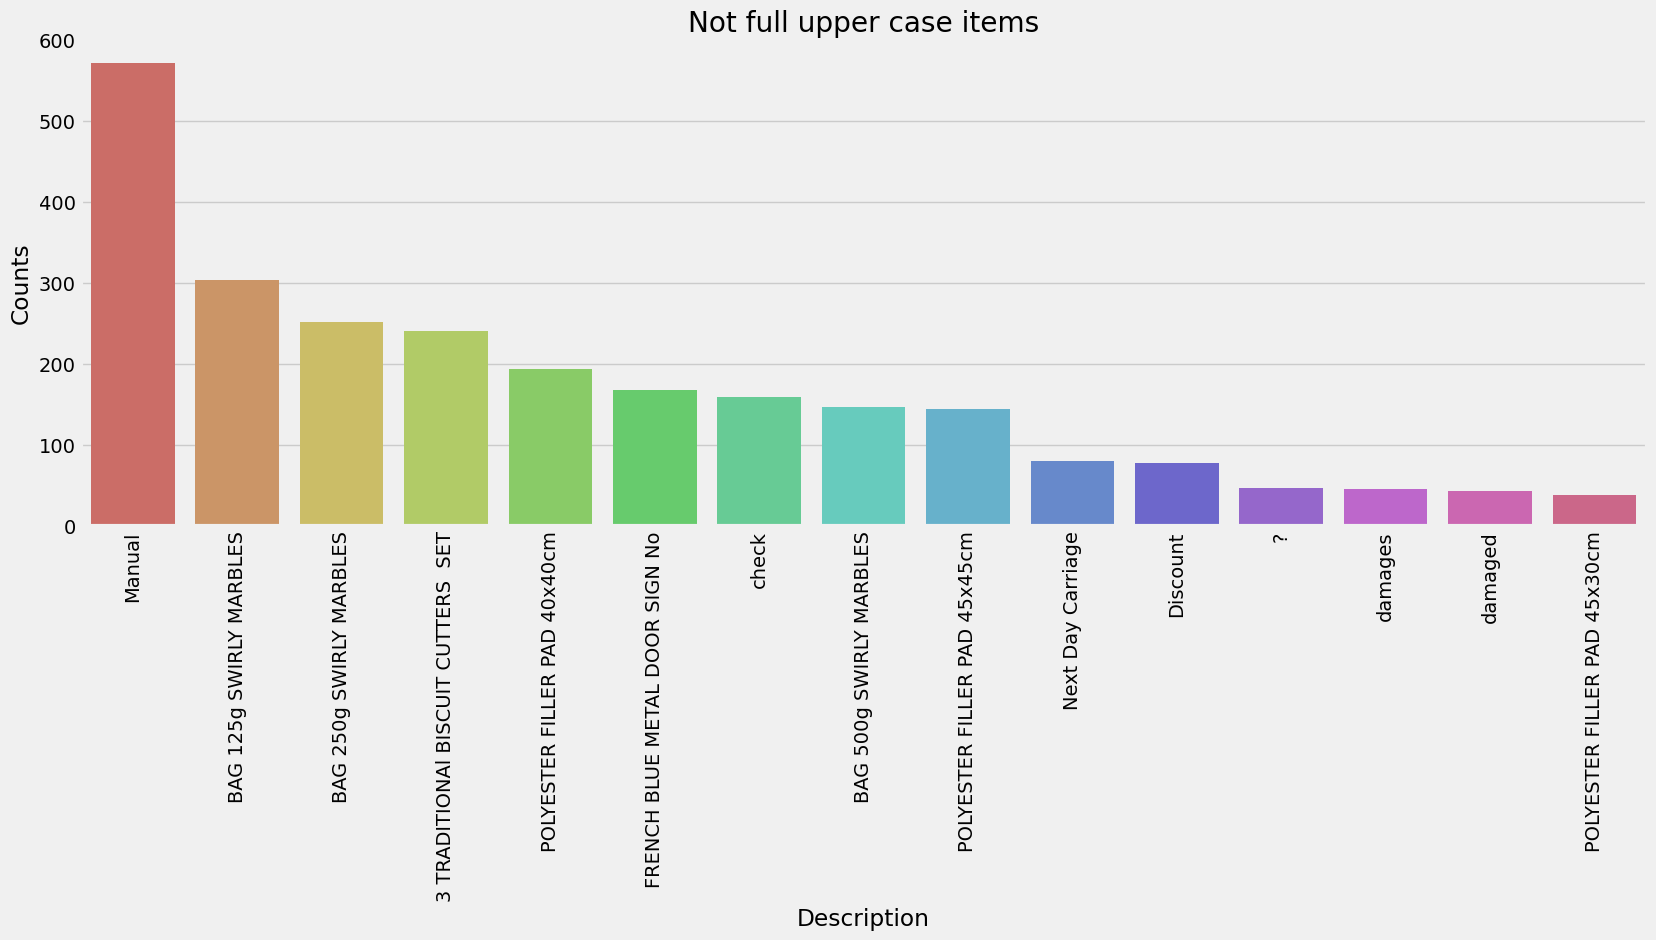

In [19]:
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=lcase_counts.index, y=lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

ALso checking out stoke codes, looks like they are deeply correlated with descriptions - which makes perfect sense.

In [20]:
df['StockCode'].value_counts().head()

StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64

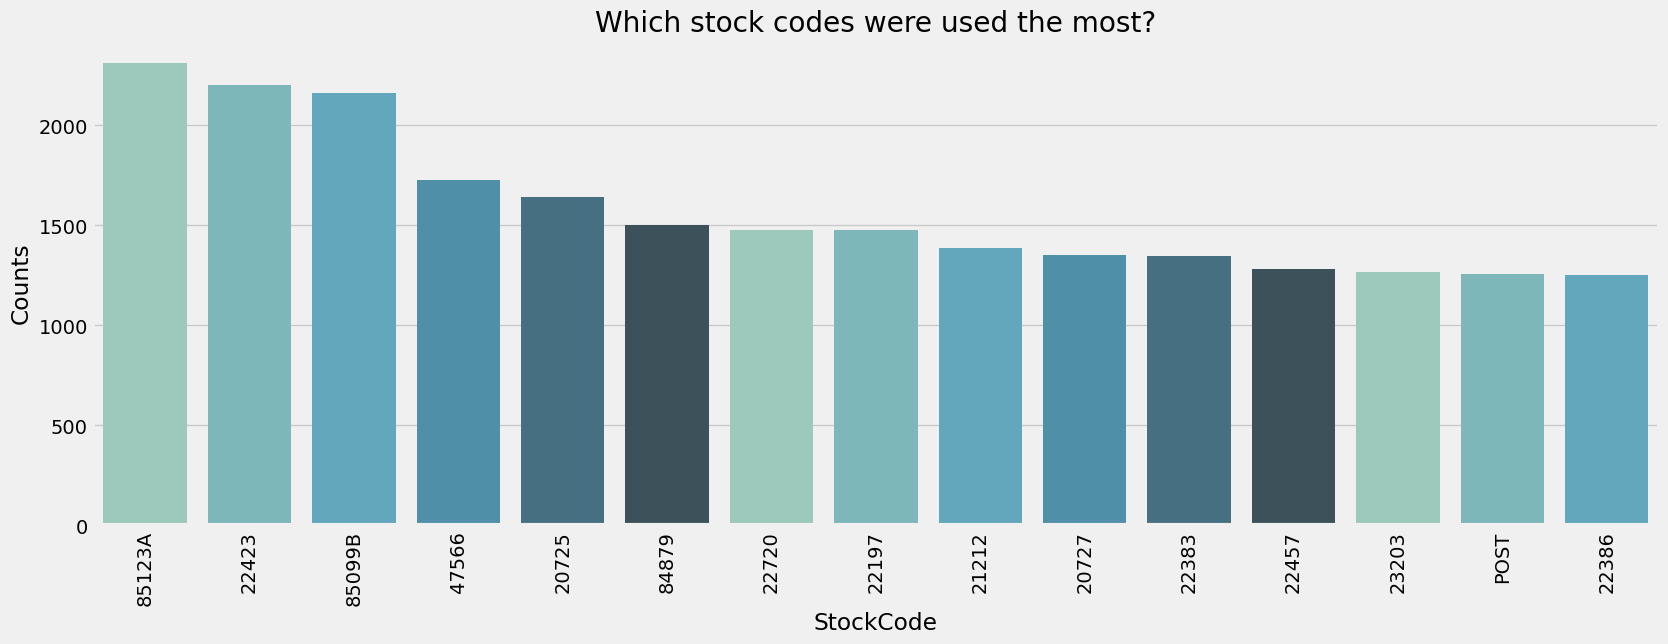

In [22]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=stock_counts.index, y=stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

Checking out also InvoiceNo feature.

In [23]:
df['InvoiceNo'].value_counts().tail()

InvoiceNo
554023     1
554022     1
554021     1
554020     1
C558901    1
Name: count, dtype: int64

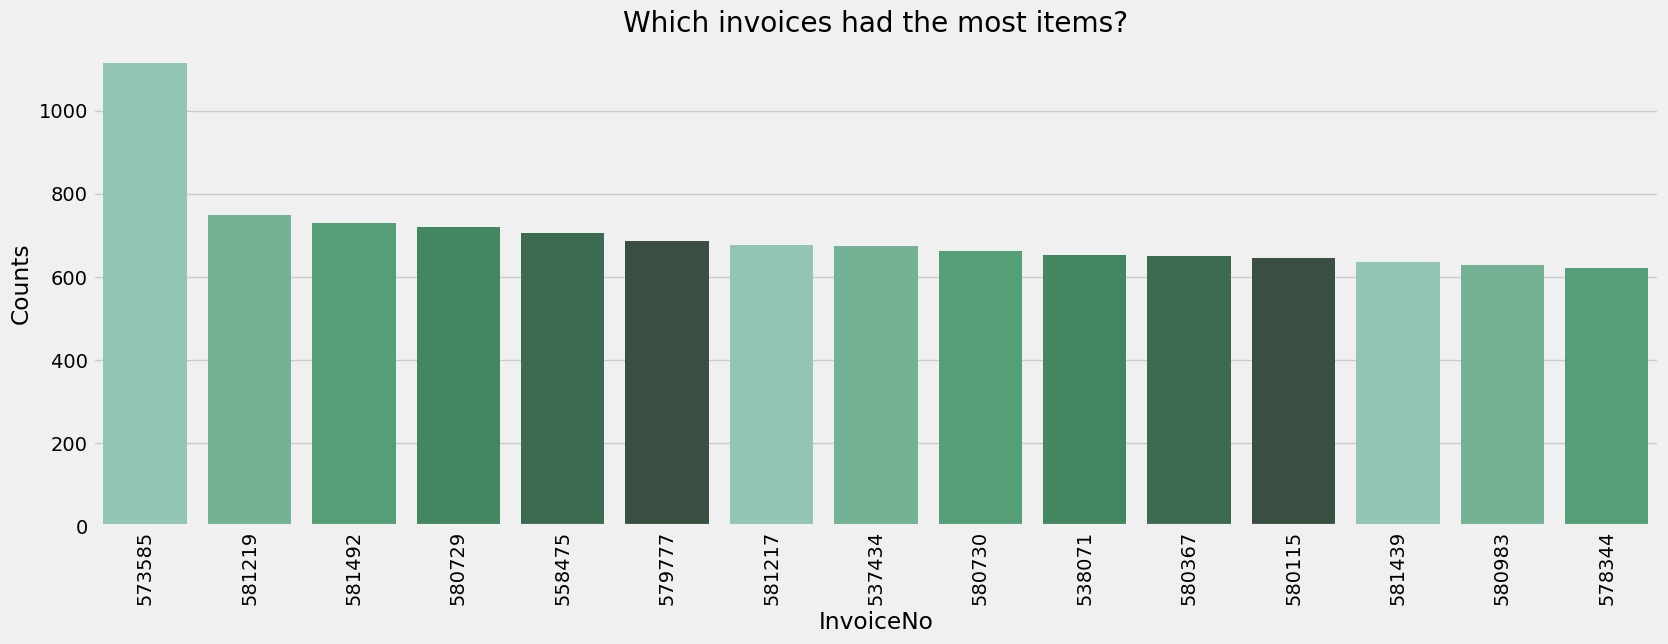

In [29]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=inv_counts.index, y=inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [30]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


Invoices starting with 'C' are "Canceling" or "Returning" invoices.
This explains the negative quantities.
For simplicity, we'll ignore these values for now instead of analyzing returns deeply.
A separate project can be started to predict returning/canceling rates for the store based on this data.

In [31]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [32]:
df.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


During exploratory data analysis we can go back to the same operations and checks, just to understand how our actions affected the dataset. EDA is the series of repetitive tasks to understand better our data. And here, for example we get back to *.describe()* method to get an overall picture of our data after some manipulations. 

We still see negative quantities and negative prices, let's get into those records.



In [33]:
# df[df['Quantity'] < 0]
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


Here we can see that other "Negative quantities" appear to be damaged/lost/unknown items. Again, we will just ignore them for the sake of simplicity of analysis for this project.

In [34]:
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


We also see negative UnitPrice, which is not normal as well. Let's check this out.

In [35]:
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [36]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


As there are just two rows, let's ignore them for the moment (description gives us enough warnings, althoug we still need some context to understand it better)

In [37]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


We've finished cleaning our data and removed all suspicious records.
Now, we can start creating new features for our model.
Let's begin with an obvious feature: Sales.
Using quantities and prices, we can calculate the revenue.

In [38]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


#  Visual EDA

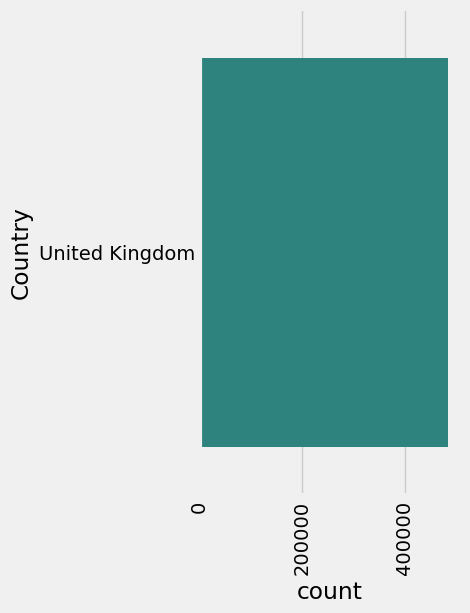

In [44]:
# For Uk
uk_data = df[df['Country'] == 'United Kingdom']

plt.figure(figsize=(3,6))
sns.countplot(y=uk_data['Country'], palette="viridis")
plt.xticks(rotation=90)
plt.show()

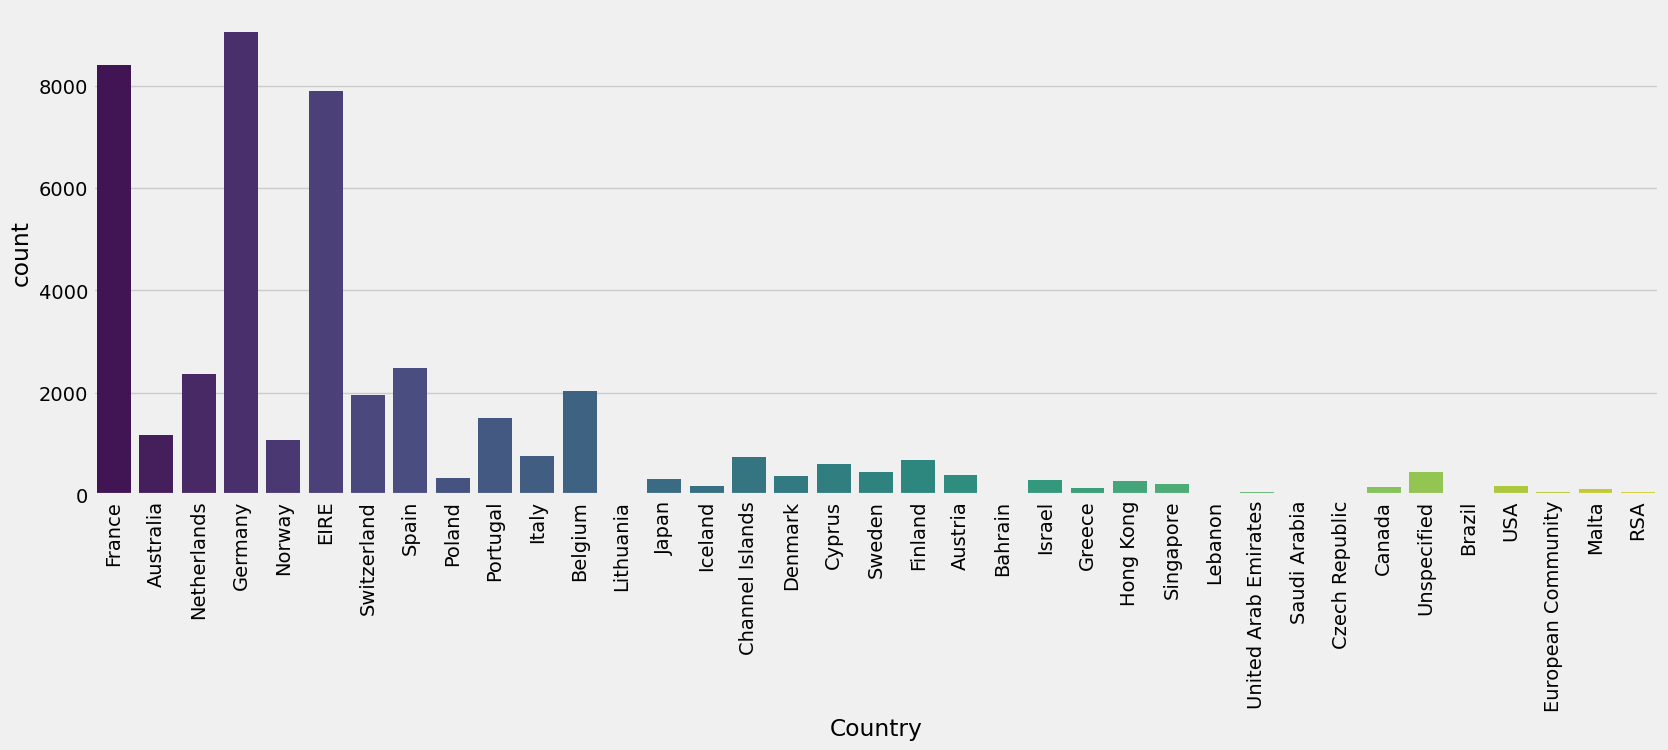

In [43]:
# For other than UK
non_uk_data = df[df['Country'] != 'United Kingdom']

plt.figure(figsize=(18,6))
sns.countplot(x=non_uk_data['Country'], palette="viridis")
plt.xticks(rotation=90)
plt.show()


In [45]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


From the plots and calculations above, it’s clear that the vast majority of sales were made in the UK, with only 8.49% making their way abroad. Our dataset is leaning heavily toward the UK, like a Brit in a pub after last call! 😆

## Detecting outliers

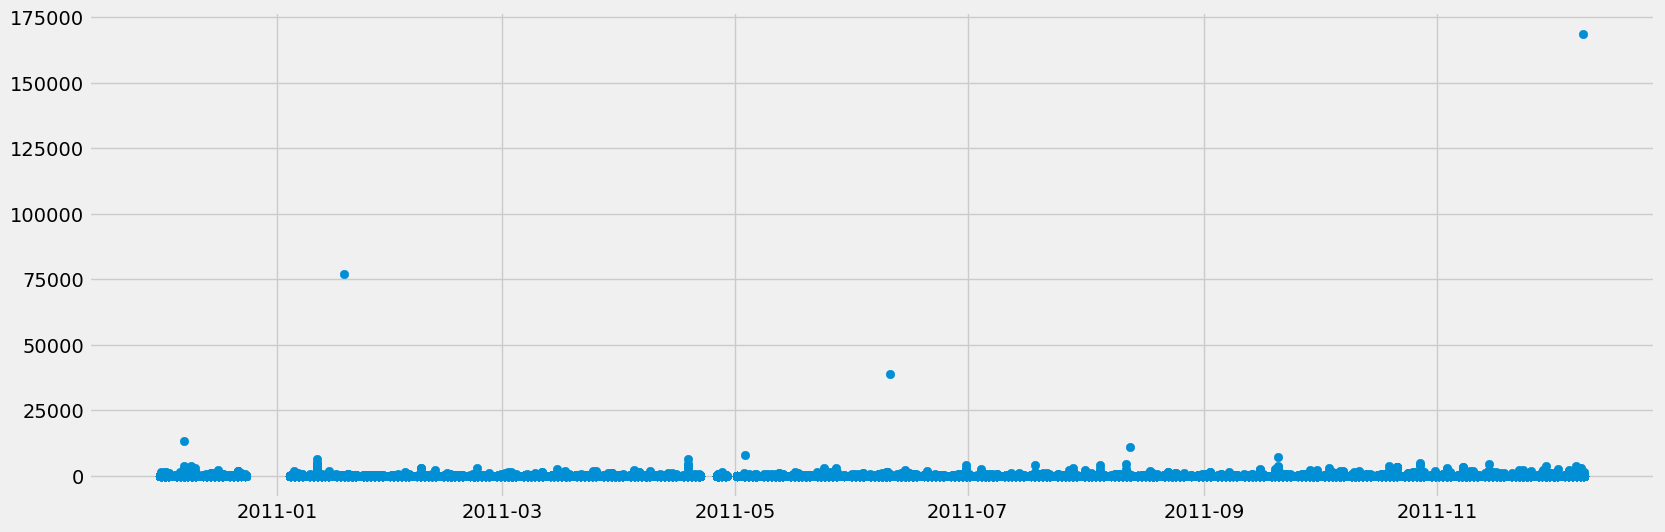

In [46]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])

Let's remove obvious outliers

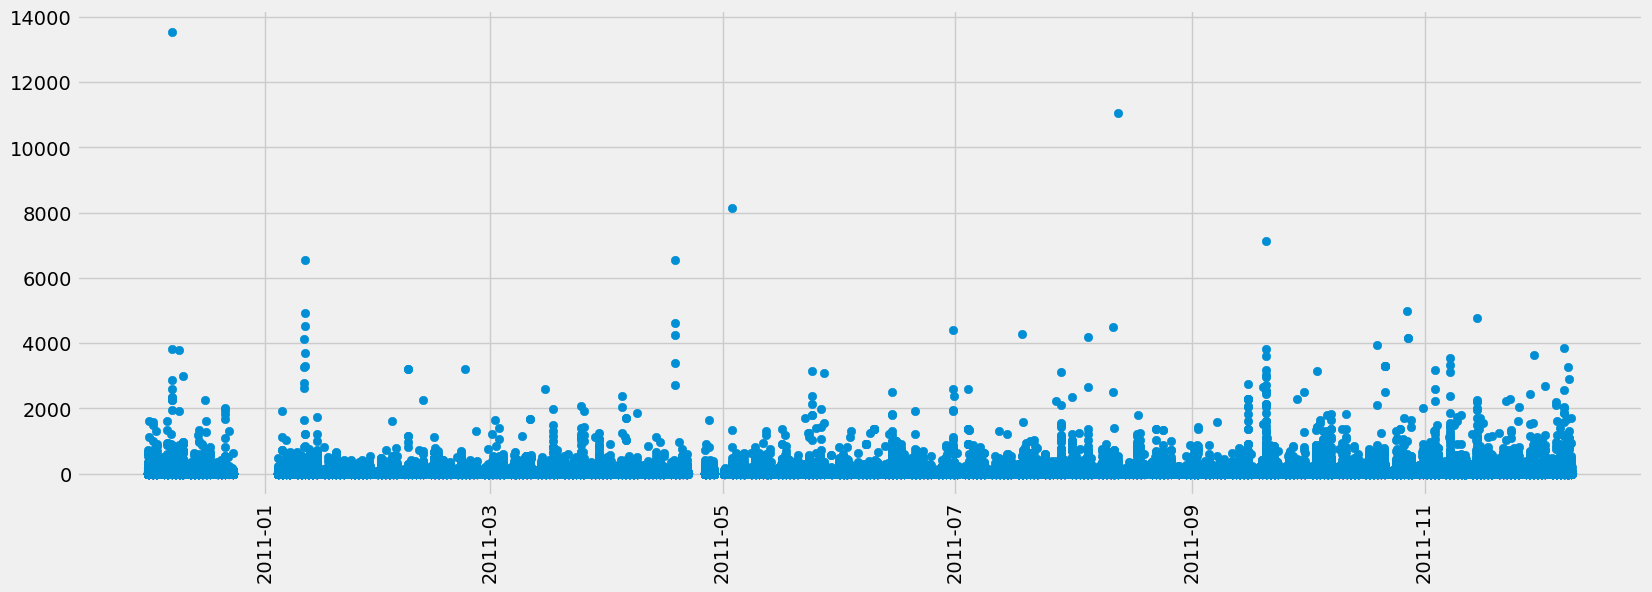

In [48]:
df = df[df['Sales'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])
plt.xticks(rotation=90)
plt.show()

In [51]:
#df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate  quantiles
quantiles = numeric_df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

# Display the quantiles
print(quantiles)

       Quantity  UnitPrice   Sales
0.050       1.0       0.42    1.25
0.950      30.0       9.95   59.70
0.980      72.0      14.95  121.68
0.990     100.0      16.98  183.60
0.999     446.4     165.00  833.79


We can see that if we remove top 2% of our data points we will get rid of absolute outliers and will have more balaced dataset.

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

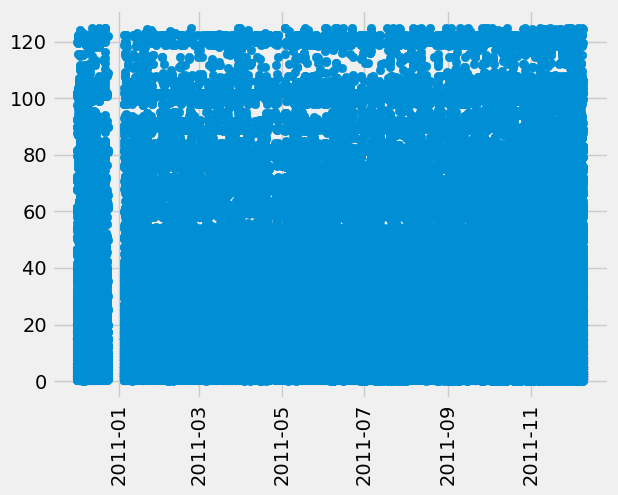

In [52]:
df_quantile = df[df['Sales'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['Sales'])
plt.xticks(rotation=90)

In [53]:
df_quantile.describe()

,Quantity,UnitPrice,Sales
count,519958.000000,519958.000000,519958.000000
mean,7.850934,3.286582,13.850263
std,15.303867,3.949021,16.330954
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.840000
75%,10.000000,4.130000,17.220000
max,1600.000000,124.870000,124.950000


## Checking distribution of numeric features

<Axes: ylabel='Density'>

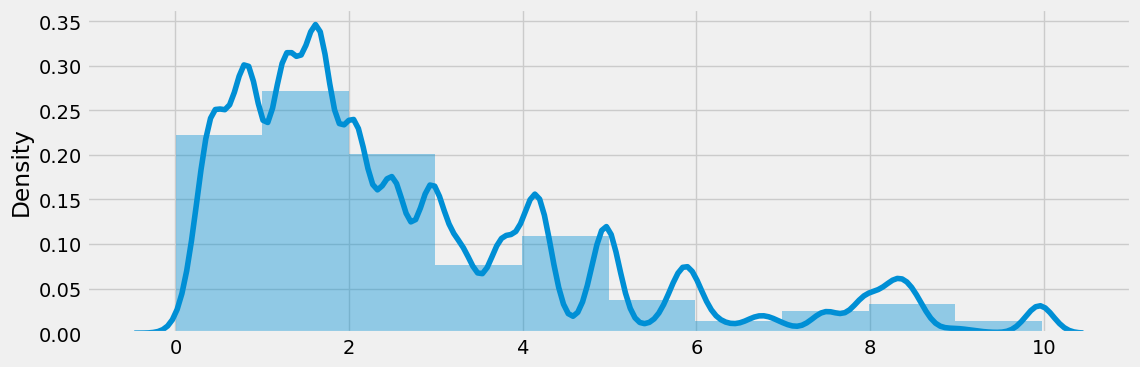

In [54]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

<Axes: ylabel='Density'>

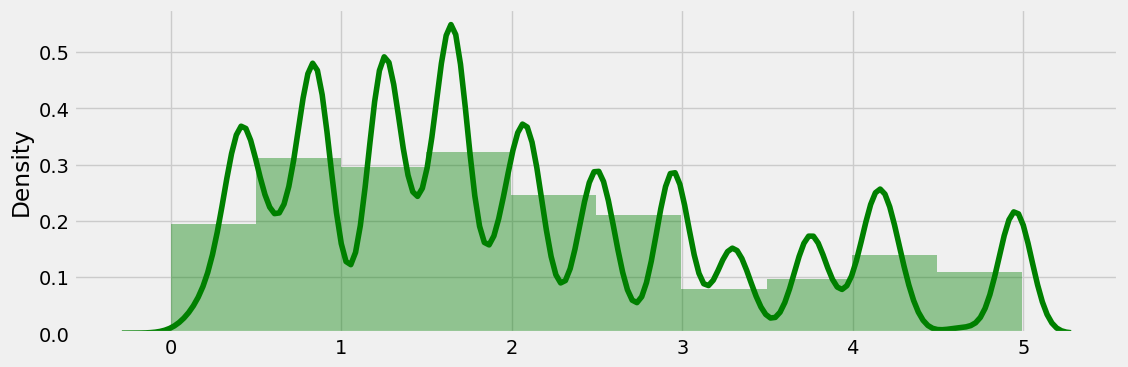

In [55]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')

From these histograms we can see that vast majority of items sold in this store has low price range - 0 to 3 pounds. 

<Axes: xlabel='Quantity', ylabel='Density'>

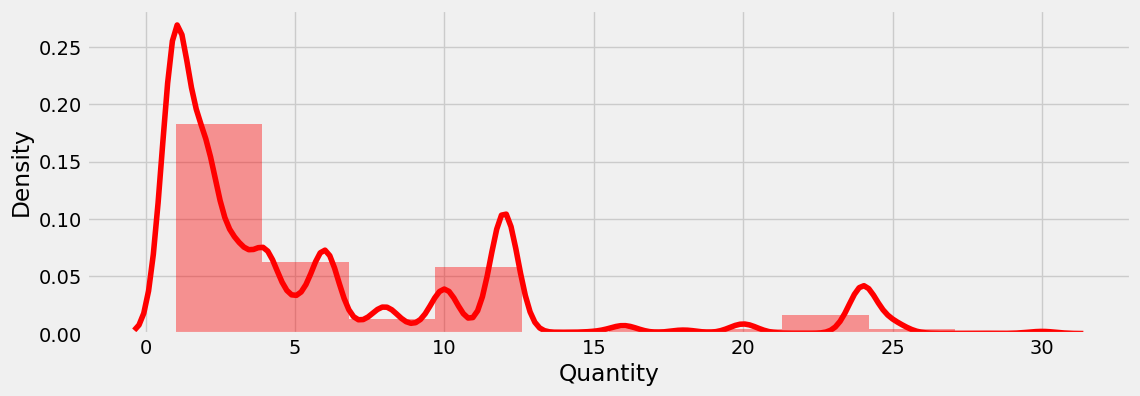

In [56]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

<Axes: xlabel='Quantity', ylabel='Density'>

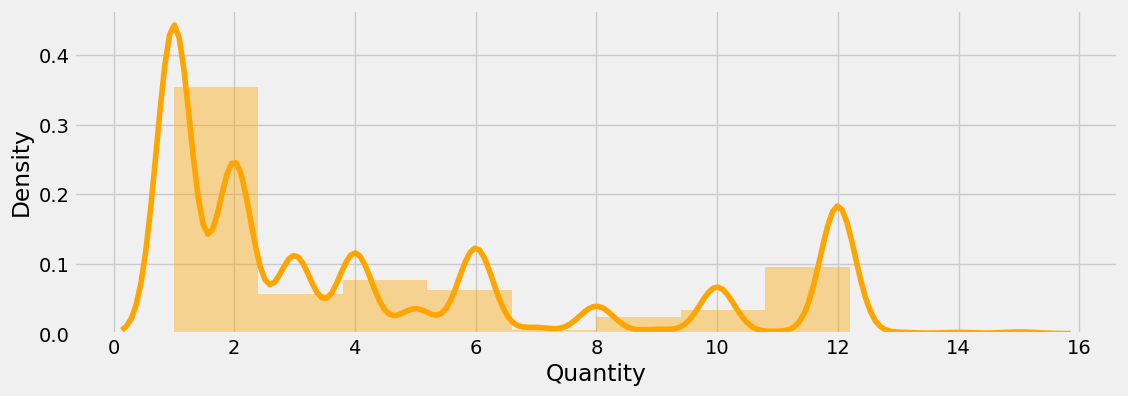

In [57]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

From these histograms we that people bought normally 1-5 items or 10-12 - maybe there were some kind of offers for sets

<Axes: xlabel='Sales', ylabel='Density'>

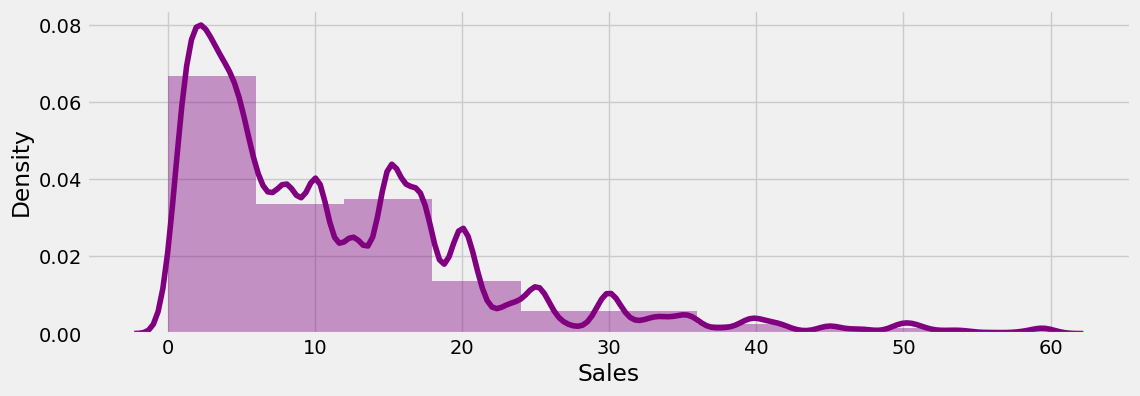

In [58]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 60]['Sales'], kde=True, bins=10, color='purple')

<Axes: xlabel='Sales', ylabel='Density'>

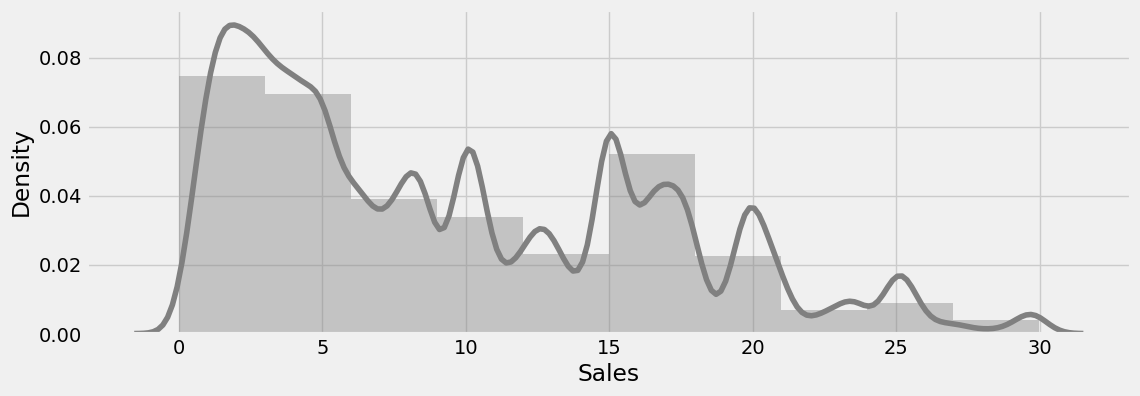

In [59]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 30]['Sales'], kde=True, bins=10, color='grey')

From these histograms we can understand that majority of sales per order were in range 1-15 pounds each.

##  Analysing sales over time

In [60]:
df_ts = df[['Sales']]
df_ts.head()

,Sales
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


As we can see every invoice has it's own timestamp (definitely based on time the order was made). We can resample time data by, for example weeks, and try see if there is any patterns in our sales.

<Figure size 1800x600 with 0 Axes>

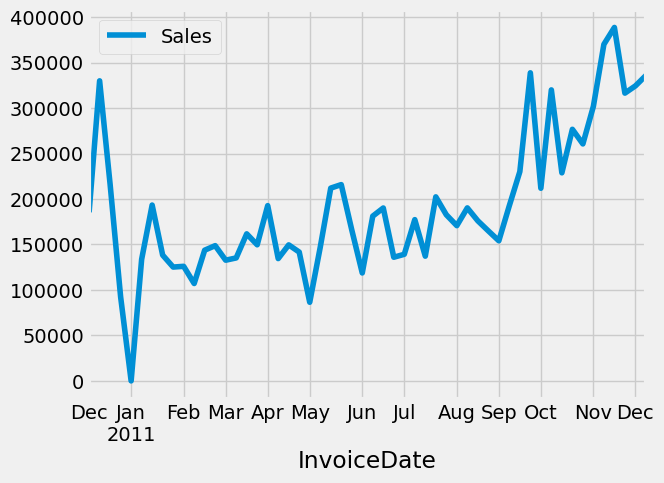

In [61]:
plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()
plt.show()

Hmm, that week with zero sales in January is giving us the stink eye. Time to put on our detective hats and investigate this shady week a bit closer! 

In [62]:
df_resample['12-2010':'01-2011']

,Sales
InvoiceDate,
2010-12-05,185427.83
2010-12-12,329936.81
2010-12-19,216012.20
2010-12-26,92369.30
2011-01-02,0.00
2011-01-09,133658.19
2011-01-16,193362.04
2011-01-23,138349.58
2011-01-30,125170.79


Ah, now it all clicks! It seems during the New Year holidays, the store probably took an extended vacation from processing orders.

# Preparing data for modeling and feature creation

Now it's time for the fun part of the project - building a model! We'll add a few more features to make our model even better. Let's get started!

In [63]:
df_clean = df[df['UnitPrice'] < 15]
df_clean.describe()

,Quantity,UnitPrice,Sales
count,520393.000000,520393.000000,520393.000000
mean,10.409364,2.978735,18.669870
std,38.123726,2.669829,64.710055
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,4.000000,2.080000,9.840000
75%,12.000000,4.130000,17.400000
max,4800.000000,14.960000,7144.720000


In [64]:
df_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=520393, freq=None)

## Quantity per invoice feature

A feature that could influence the sales output could be "Quantity per invoice". Let's find the data for this feature.

In [65]:
df_join = df_clean.groupby('InvoiceNo')[['Quantity']].sum()

In [66]:
df_join = df_join.reset_index()
df_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [67]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how='left', on='InvoiceNo')
df_clean = df_clean.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
df_clean.tail(15)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv
520378,581587,22631,CIRCUS PARADE LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520379,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,France,19.80,2011-12-09 12:50:00,105
520380,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,France,19.80,2011-12-09 12:50:00,105
520381,581587,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,France,15.00,2011-12-09 12:50:00,105
520382,581587,22727,ALARM CLOCK BAKELIKE RED,4,3.75,France,15.00,2011-12-09 12:50:00,105
520383,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,3.75,France,15.00,2011-12-09 12:50:00,105
520384,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,France,15.00,2011-12-09 12:50:00,105
520385,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,France,15.60,2011-12-09 12:50:00,105
520386,581587,22629,SPACEBOY LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520387,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,4.15,France,16.60,2011-12-09 12:50:00,105


In [68]:
df_clean.describe()

,Quantity,UnitPrice,Sales,InvoiceDate,QuantityInv
count,520393.000000,520393.000000,520393.000000,520393,520393.000000
mean,10.409364,2.978735,18.669870,2011-07-05 01:44:18.499941632,533.328732
min,1.000000,0.001000,0.001000,2010-12-01 08:26:00,1.000000
25%,1.000000,1.250000,3.750000,2011-03-28 13:28:00,152.000000
50%,4.000000,2.080000,9.840000,2011-07-20 16:12:00,300.000000
75%,12.000000,4.130000,17.400000,2011-10-19 13:58:00,567.000000
max,4800.000000,14.960000,7144.720000,2011-12-09 12:50:00,15049.000000
std,38.123726,2.669829,64.710055,NaN,890.339855


In [69]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [70]:
df_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
Sales                 float64
InvoiceDate    datetime64[ns]
QuantityInv             int64
dtype: object

## Grouping Quantity and UnitPrice into buckets

After our previous analysis, we can categorize these features into 6 buckets for Quantity and 5 for UnitPrice using the pandas .cut() method.

In [71]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins=bins_p)
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


##  Extracting and grouping dates 

We've observed that gift sales vary with the seasons: they peak in Q4, drop sharply in Q1 of the following year, and steadily rise until reaching a new peak in Q4 again. Based on this pattern, we can create a new feature that could enhance our model.

In [72]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [73]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
df_clean.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
520388,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,10.20,2011-12-09 12:50:00,105,"(11, 14]","(0, 1]",12,"(9, 12]"
520389,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,12.60,2011-12-09 12:50:00,105,"(5, 8]","(2, 3]",12,"(9, 12]"
520390,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520391,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520392,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,France,14.85,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"


# Building a model

## Splitting data into UK and non-UK

We need to analyze these two datasets separately to ensure our data is more standardized for modeling. Different countries may exhibit unique patterns that work differently from the UK. Additionally, we can test a hypothesis: does a model built for the UK perform well when applied to data from other countries?

In [74]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

In [75]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


## Extracting features and creating dummy variables

In [76]:
df_uk_model = df_uk[['Sales', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]
df_uk_model.head()

,Sales,QuantityInv,QuantityRange,PriceRange,DateRange
0,15.30,40,"(5, 8]","(2, 3]","(9, 12]"
1,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
2,22.00,40,"(5, 8]","(2, 3]","(9, 12]"
3,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
4,20.34,40,"(5, 8]","(3, 4]","(9, 12]"


In [77]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')
df_data.head()

,Sales,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
1,20.34,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,22.00,40,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True
3,20.34,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
4,20.34,40,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True


## Scaling

Since most of our features fall within the 0-1 range, it would be logical to scale the "QuantityInv" feature as well. Generally, scaling features is a good practice that can improve model performance.

In [78]:
from sklearn.preprocessing import scale
df_data['QuantityInv'] = scale(df_data['QuantityInv'])

## Train-Test Split

In [79]:
y = df_data['Sales']
X = df_data.drop(columns=['Sales'])

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

## Testing and validating different models

Here, we're employing GridSearch and CrossValidation to evaluate three types of regressors: Linear, DecisionTree, and RandomForest. 

In [81]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression
fit_intercepts = [True, False]
param_grid_linear = dict(fit_intercept=fit_intercepts)
linear_model = LinearRegression()

# Decision Tree
min_tree_splits = range(2,3)
min_tree_leaves = range(2,3)
param_grid_tree = dict(min_samples_split=min_tree_splits,
                       min_samples_leaf=min_tree_leaves)
tree_model = DecisionTreeRegressor()

# Random Forest
estimators_space = [100]
min_sample_splits = range(2,4)
min_sample_leaves = range(2,3)
param_grid_forest = dict(min_samples_split=min_sample_splits,
                       min_samples_leaf=min_sample_leaves,
                       n_estimators=estimators_space)
forest_model = RandomForestRegressor()

cv = 5

models_to_test = ['LinearRegression','DecisionTreeRegressor','RandomForest']
regression_dict = dict(LinearRegression=linear_model,
                       DecisionTreeRegressor=tree_model,
                       RandomForest=forest_model)
param_grid_dict = dict(LinearRegression=param_grid_linear,
                       DecisionTreeRegressor=param_grid_tree,
                       RandomForest=param_grid_forest)

score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}
best_est_dict = {}

for model in models_to_test:
  regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv=cv, n_jobs=-1)

  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  # Print the tuned parameters and score
  print(" === Start report for regressor {} ===".format(model))
  score_dict[model] = regressor.best_score_
  print("Tuned Parameters: {}".format(regressor.best_params_)) 
  params_dict = regressor.best_params_
  print("Best score is {}".format(regressor.best_score_))

  # Compute metrics
  mae_dict[model] = mean_absolute_error(y_test, y_pred)
  print("MAE for {}".format(model))
  print(mean_absolute_error(y_test, y_pred))
  mse_dict[model] = mean_squared_error(y_test, y_pred)
  print("MSE for {}".format(model))
  print(mean_squared_error(y_test, y_pred))
  r2_dict[model] = r2_score(y_test, y_pred)
  print("R2 score for {}".format(model))
  print(r2_score(y_test, y_pred))
  print(" === End of report for regressor {} === \n".format(model))
  
  # Add best estimator to the dict
  best_est_dict[model] = regressor.best_estimator_



 === Start report for regressor LinearRegression ===
Tuned Parameters: {'fit_intercept': False}
Best score is 0.1742400229357121
MAE for LinearRegression
15.083094838811652
MSE for LinearRegression
3919.00436196598
R2 score for LinearRegression
0.15627428605338267
 === End of report for regressor LinearRegression === 

 === Start report for regressor DecisionTreeRegressor ===
Tuned Parameters: {'min_samples_leaf': 2, 'min_samples_split': 2}
Best score is 0.39027917809000046
MAE for DecisionTreeRegressor
6.751837309172617
MSE for DecisionTreeRegressor
1995.9393099932206
R2 score for DecisionTreeRegressor
0.5702925631668977
 === End of report for regressor DecisionTreeRegressor === 

 === Start report for regressor RandomForest ===
Tuned Parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score is 0.4401108396765004
MAE for RandomForest
6.735419314121193
MSE for RandomForest
1946.3841082409856
R2 score for RandomForest
0.580961343835771
 === End of repor

<Axes: title={'center': 'Regressor Comparison'}, xlabel='Best Score', ylabel='Regressor'>

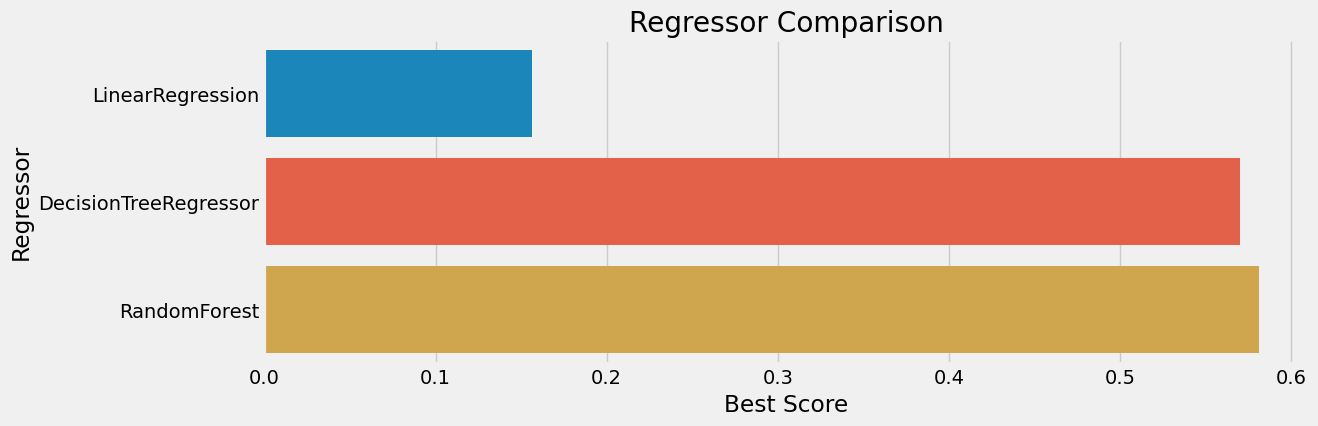

In [82]:
# Creating summary report
summary_cols = ['Best Score']
summary = pd.DataFrame.from_dict(r2_dict, orient='index')
summary.index.name = 'Regressor'
summary.columns = summary_cols
summary = summary.reset_index()

# Visualizing results
plt.figure(figsize=(12,4))
plt.xlabel('Best score')
plt.title('Regressor Comparison')

sns.barplot(x='Best Score', y='Regressor', data=summary)

# Conclusions


This is a simple analysis of a dataset where a model predicts sales. However, there are many ways we can make it better:

* Explore cluster analysis and create new features from it.
* Dive deeper into date segmentation.
* Extract more insights from descriptions and stock numbers.
* Compare sales between domestic and international markets.
* Experiment with deep learning models.

Also, we can fine-tune our model's hyperparameters and allocate more time for training.
The Random Forest Regressor seems to be our best model so far, achieving an R2 score above 0.6, which is quite decent.
